# Introduction


Waste disposal raises multiple concerns such as eutrophication and pollution of land, air, or water due to toxic waste consumption by animals. Segregating waste into organic and recyclable categories is a recommended practice. However, manual sorting is highly labor-intensive. Therefore, leveraging machine learning for automated classification, as indicated by the dataset, is proposed as a solution.Hence, the [dataset](https://www.kaggle.com/techsash/waste-classification-data) suggests the use of ML to automate the classification process.


We are going to use pytorch in our project. 

## Step 1: Importing libraries and check if CUDA is available.

In [5]:
import torch
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


## Step 2: Data Augmentation

Data Augmentation is basically cropping, resizing, flipping the image data to get more accurate results. This can be done in PyTorch using **transforms** . Also, Normalization helps get data within a range and reduces the skewness which helps learn faster and better. Normalization is done in PyTorch by **transforms.Normalize** wherein two tuples are passed, one tuple has mean for all the three RGB channels followed by the second tuple having standard deviation for all three channels. Data Augmentation is mostly done in training data as it is important to have more accuracy in training so that eventually test accuracy is better. This also increases the amount of training images. Hence, multiple augmentations can be applied on train samples.

In [6]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

Loading the directories and training, testing data.

In [7]:
data_dir = r'C:\Users\pintoo\Desktop\EPICS PROJECT\waste classification data\DATASET'
train_data = datasets.ImageFolder(data_dir + r'\TRAIN', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + r'\TEST', transform=test_transforms)


In deep learning, often the training set is split into train samples and validation samples to cross check accuracies. This is done using **SubsetRandomSampler**.

The DataLoader takes a dataset (such as you would get from ImageFolder) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.

In [8]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [9]:
print(len(train_loader))

565


In [10]:
#defining classes

classes=['O','R']

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 

Plotting the images to understand the data. 
O= Organic Waste
R= Recyclable Waste

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

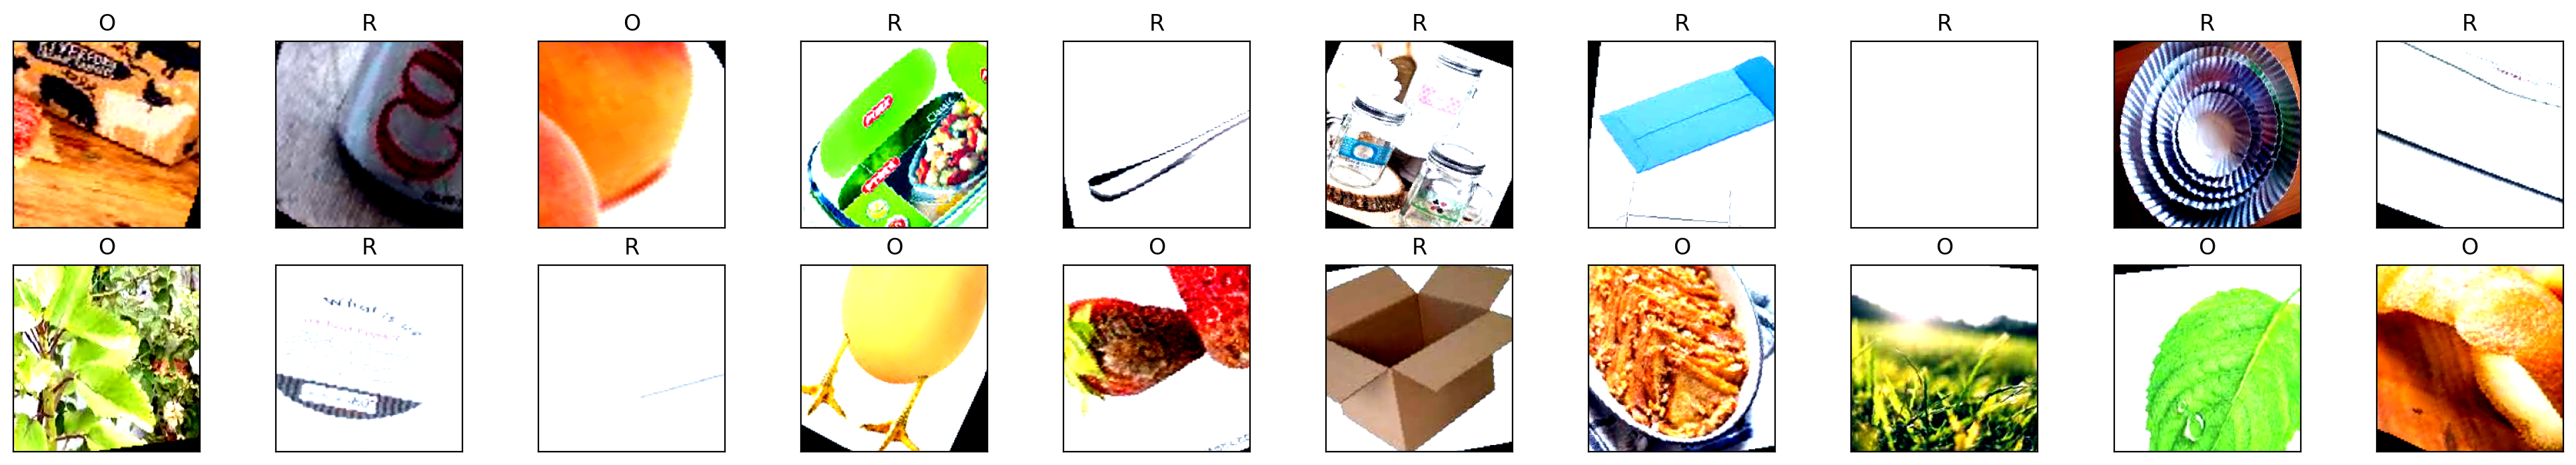

In [12]:
# obtain one batch of training images
dataiter = iter(train_loader)
# images, labels = dataiter.next()
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])
tensor(1)


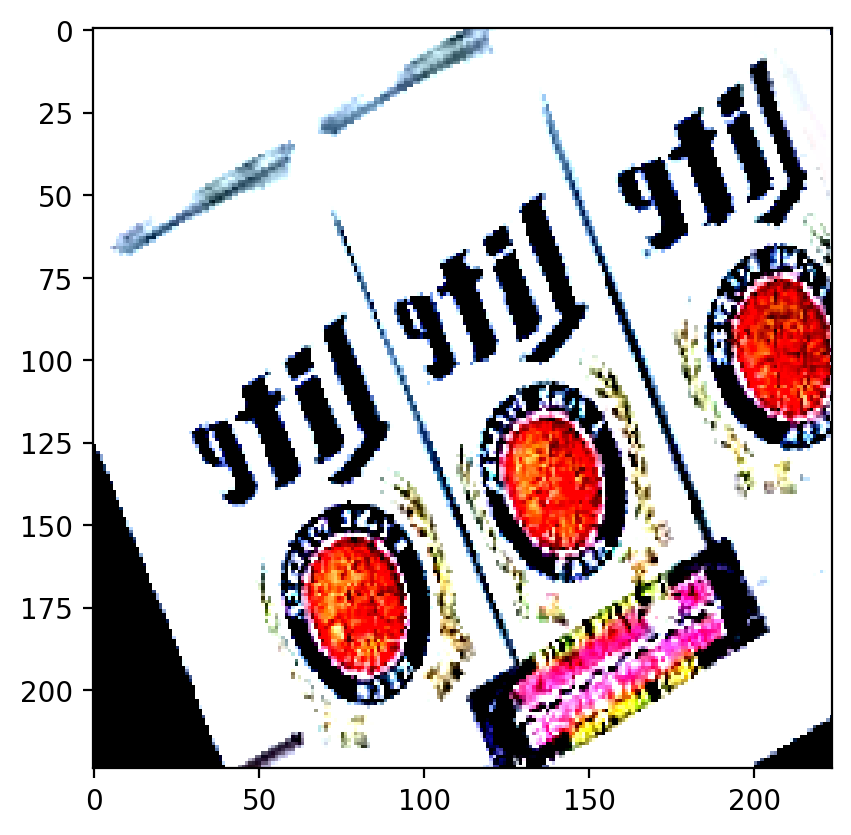

In [13]:
batch = next(iter(train_loader))
print(batch[0].shape)
plt.imshow(batch[0][0].permute(1, 2, 0))
print(batch[1][0])

# Transfer Learning

Transfer Learning refers to the process of using already existing pre-trained models for other applications by tweaking the last few layers and using it to classify our desired classes.
Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our organic and recyclable waste photos with near perfect accuracy.

With `torchvision.models` these pre-trained networks can be downloaded and used in applications.

Here, the DenseNet121 is used. DenseNet is a very powerful model with 121 layers.
For more information about densenet, [Click Here](https://www.kaggle.com/pytorch/densenet121).

## Densenet architecture
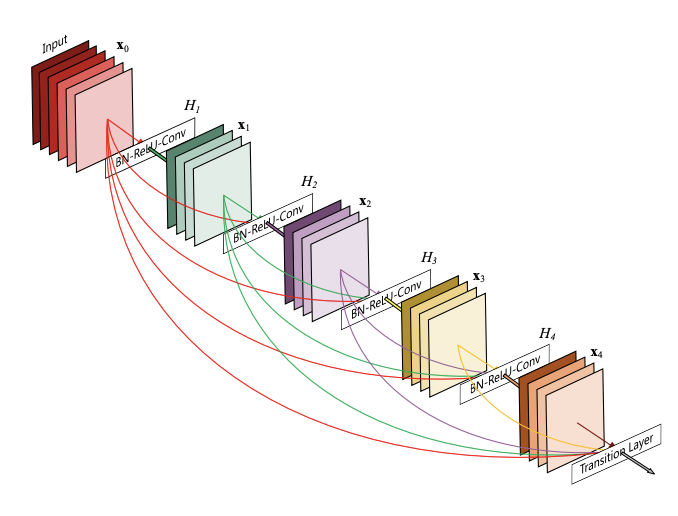

Img source:https://pytorch.org/hub/pytorch_vision_densenet/

Dense Convolutional Network (DenseNet), connects each layer to every other layer in a feed-forward fashion. The 1-crop error rates on the imagenet dataset with the pretrained model are 25.35 for top-1 error and 7.83 for top-5 error.

In [14]:
model = models.densenet121(pretrained=True)
model

C:\Users\pintoo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\pintoo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [15]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

# Training the Model

Training the model for desired number of epochs and keeping track of train loss and validation loss. If the validation loss decreases, the model is saved.The simplest thing to do is simply save the state dict with `torch.save`.

In [28]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_waste.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.300196 	Validation Loss: 0.312278
Validation loss decreased (inf --> 0.312278).  Saving model ...
Epoch: 2 	Training Loss: 0.255958 	Validation Loss: 0.213042
Validation loss decreased (0.312278 --> 0.213042).  Saving model ...
Epoch: 3 	Training Loss: 0.235990 	Validation Loss: 0.206464
Validation loss decreased (0.213042 --> 0.206464).  Saving model ...
Epoch: 4 	Training Loss: 0.236506 	Validation Loss: 0.217614
Epoch: 5 	Training Loss: 0.229986 	Validation Loss: 0.207588
Epoch: 6 	Training Loss: 0.233450 	Validation Loss: 0.199507
Validation loss decreased (0.206464 --> 0.199507).  Saving model ...
Epoch: 7 	Training Loss: 0.222976 	Validation Loss: 0.201736
Epoch: 8 	Training Loss: 0.220735 	Validation Loss: 0.228033
Epoch: 9 	Training Loss: 0.216805 	Validation Loss: 0.193980
Validation loss decreased (0.199507 --> 0.193980).  Saving model ...
Epoch: 10 	Training Loss: 0.216173 	Validation Loss: 0.202743
Epoch: 11 	Training Loss: 0.215030 	Validation Lo

Loading the last saved model for testing.

In [16]:
model.load_state_dict(torch.load('model_waste.pt'))

<All keys matched successfully>

# Testing the model

In [17]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(2):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.184592

Test Accuracy of     O: 100% (88/88)
Test Accuracy of     R: 91% (64/70)

Test Accuracy (Overall): 96% (152/158)


The model has 91% accuracy for Recyclable waste. But, a whopping 98% accuracy for organic waste.

In [21]:
test_loader

# Visualizing the Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

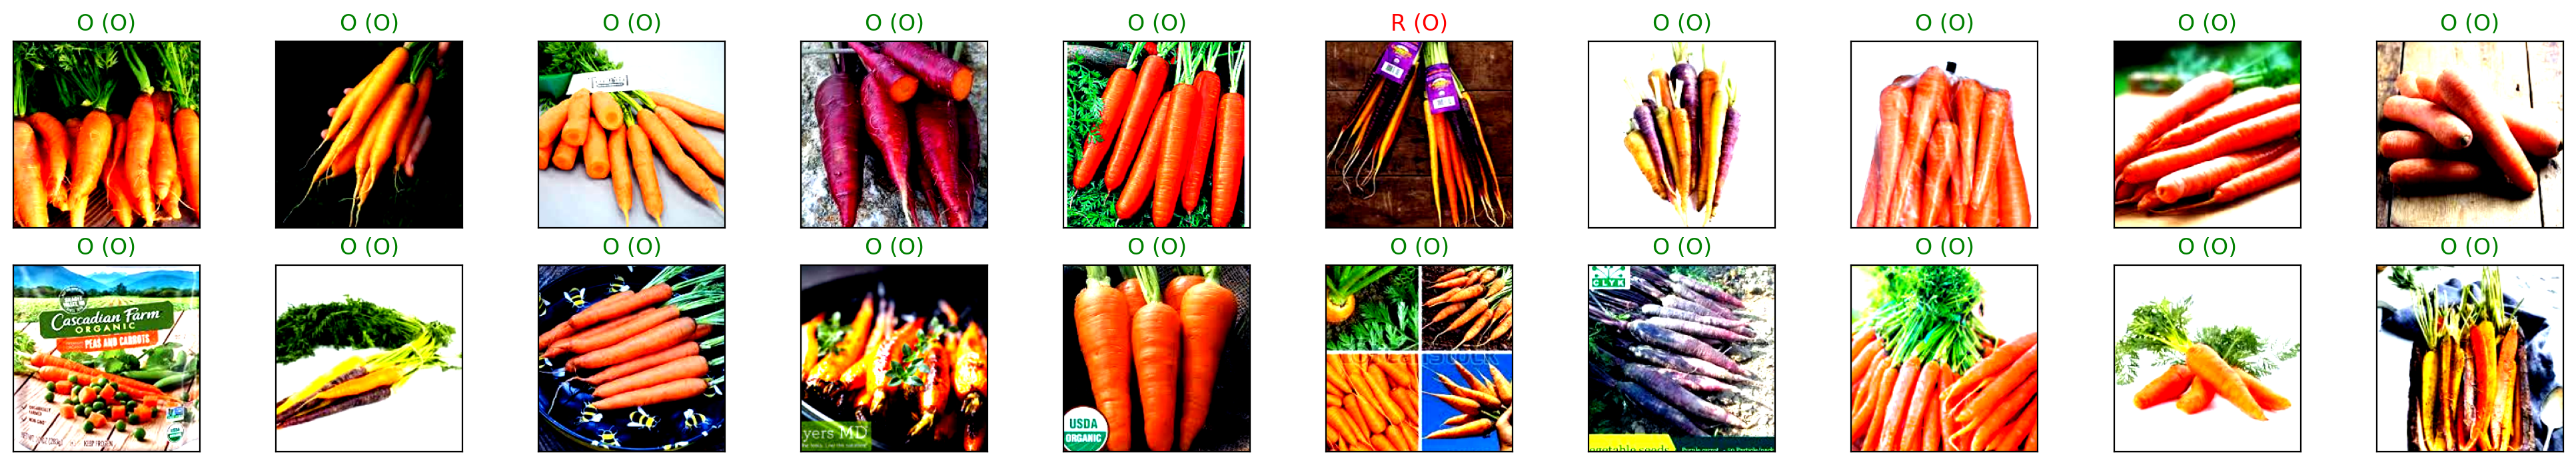

In [33]:
# obtain one batch of test images
dataiter = iter(test_loader)
# images, labels = dataiter.next()
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [24]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image

# Define a function to predict the class from an image file
def predict_image(image_path, model, transform):
    # Load and preprocess the image
    image = Image.open(image_path)
    image_tensor = transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)  # Add batch dimension

    # If GPU is available, move the tensor to GPU
    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()

    # Set the model to evaluation mode
    model.eval()

    # Perform the inference
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
    
    # Find the predicted class index
    predicted_class = torch.argmax(probabilities).item()

    return predicted_class, probabilities


# Example of loading a pretrained model (replace with your model loading code)
class YourModel(torch.nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        # Define your model architecture here
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size)
        # Add more layers as needed

    def forward(self, x):
        # Define the forward pass
        x = self.conv1(x)
        # Add more layers as needed
        return x

# Initialize your model
model = YourModel()

# Load the saved model state (weights)
model_path = 'model_waste.pt'
model.load_state_dict(torch.load(model_path))
if torch.cuda.is_available():
    model.cuda()

# Define the transformation to apply to your image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the same size as used during training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize as used during training
])

# Specify the path to your single image
image_path = 'path/to/your/single/image.jpg'

# Predict the class of the image
predicted_class, probabilities = predict_image(image_path, model, transform)

# Print the results
print(f'Predicted Class: {predicted_class}')
print(f'Probabilities: {probabilities}')


NameError: name 'in_channels' is not defined